In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [5]:
areas = [1, 2, 3, 10, 11, 12, 13, 14]
np.mean(areas), np.median(areas)

(8.25, 10.5)

\begin{align}
        p(\textbf{z}|c) &= \mathcal{C}_d(\kappa)\exp\left(\kappa\mu^T_{c}\textbf{z}\right)\\
        \mathcal{C}_d(\kappa) &= \frac{(\kappa)^{d/2-1}}{(2\pi)^{d/2}\mathcal{I}_{d/2-1}(\kappa)}
\end{align}

With d=2:

In [6]:
from scipy.special import iv


def z_Prob(z, mus, kappa, d=2, beta=0.5):
    K = mus.shape[-1]
    p_c = (1 - beta) / K
    class_probs = np.array([z_vonMises_dencity(z, mu, kappa) for mu in mus.T])
    return np.sum(class_probs * p_c) + (1 / (2 * np.pi)) * beta


def z_class_prob(class_id, z, mus, kappa, d=2, beta=0.5):
    p_z = z_Prob(z, mus, kappa, d, beta)
    K = mus.shape[1]
    if class_id == K:
        p_c = beta
        return (1 / (2 * np.pi)) * p_c / p_z
    else:
        p_c = (1 - beta) / K
        return (z_vonMises_dencity(z, mus[:, class_id], kappa) * p_c) / p_z


def z_vonMises_dencity(z, mu_c, kappa, d=2):
    C_d = kappa ** (d / 2 - 1) / ((2 * np.pi) ** (d / 2) * iv(d / 2 - 1, kappa))
    return C_d * np.exp(kappa * np.dot(z, mu_c))

In [7]:
def get_vectors_by_angle(angles):
    return np.array([[np.cos(plot_angle), np.sin(plot_angle)] for plot_angle in angles])


def compute_class_probs(class_id, zs, mus, kappa, beta):
    class_probes = []
    for z in zs:
        class_prob = z_class_prob(class_id, z, mus, kappa, beta=beta)
        class_probes.append(class_prob)
    class_probes = np.array(class_probes)
    return class_probes

### False Identification example

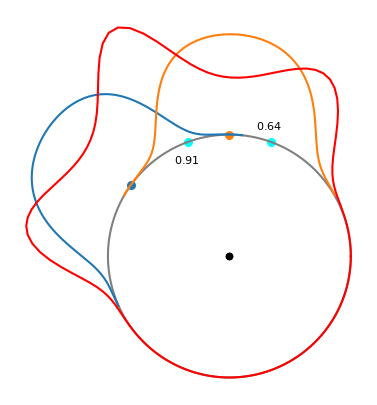

In [8]:
gallery_class_angles = [0.4, 0.25]
ident_uncertain_test_point = (
    gallery_class_angles[-1] + gallery_class_angles[-2]
) / 2 - 0.02
test_points_angles = [
    ident_uncertain_test_point,
    gallery_class_angles[-1] - (ident_uncertain_test_point - gallery_class_angles[-1]),
]

gallery_class_angles = np.array(gallery_class_angles) * 2 * np.pi
test_points_angles = np.array(test_points_angles) * 2 * np.pi
theta = np.linspace(0, 2 * np.pi, 150)
a = np.cos(theta)
b = np.sin(theta)
kappa = 15
beta = 0.5


dot_size = 30
colors = list(mcolors.TABLEAU_COLORS)[: len(gallery_class_angles)]
test_color = "cyan"
fig, ax = plt.subplots(figsize=(5, 5))
# plot circle
ax.plot(a, b, color="gray")

draw_dencity_angles = np.linspace(-np.pi / 3, np.pi / 3, 150)

mus = np.stack([np.cos(gallery_class_angles), np.sin(gallery_class_angles)], axis=0)
class_to_class_probs = []

for i, (angle, color) in enumerate(zip(gallery_class_angles, colors)):
    mu_c = mus[:, i]
    plot_angles = angle + draw_dencity_angles
    zs = get_vectors_by_angle(plot_angles)
    class_probes = compute_class_probs(i, zs, mus, kappa, beta)
    v = zs.T * (1 + class_probes[np.newaxis, :])
    ax.plot(v[0], v[1], c=color)

    ax.scatter([np.cos(angle)], [np.sin(angle)], c=color, s=dot_size)
    ax.scatter([0], [0], color="black", s=20)

    # plot decity
    # ax.scatter(points[:, 0], points[:, 1], color=color, s=3)

# plot_uniform_prob
zs = get_vectors_by_angle(theta)
class_probes = compute_class_probs(mus.shape[1], zs, mus, kappa, beta)
v = zs.T * (1 + class_probes[np.newaxis, :])
# ax.plot(v[0], v[1], color='black')

# plot entropy

all_probs = []
for i in range(mus.shape[1] + 1):
    class_probes = compute_class_probs(i, zs, mus, kappa, beta)
    all_probs.append(class_probes)
all_probs = np.stack(all_probs, axis=0)
entr = -np.sum(all_probs * np.log(all_probs), axis=0)

v = zs.T * (1 + entr[np.newaxis, :])
ax.plot(v[0], v[1], color="red")

# plot test points
for test_angle in test_points_angles:
    ax.scatter([np.cos(test_angle)], [np.sin(test_angle)], c=test_color, s=dot_size)

test_point_vectors = get_vectors_by_angle(test_points_angles)
# entropy value

probs_at_test_points = []
for i in range(mus.shape[1] + 1):
    class_probes = compute_class_probs(i, test_point_vectors, mus, kappa, beta)
    probs_at_test_points.append(class_probes)
probs_at_test_points = np.stack(probs_at_test_points, axis=0)

entr_test = -np.sum(probs_at_test_points * np.log(probs_at_test_points), axis=0)
entr_test = np.round(entr_test, 2)
ax.annotate(
    f"${entr_test[0]}$",
    xy=test_point_vectors[0],
    xytext=[test_point_vectors[0][0] - 0.12, test_point_vectors[0][1] - 0.18],
    fontsize=8,
)
ax.annotate(
    f"${entr_test[1]}$",
    xy=test_point_vectors[1],
    xytext=[test_point_vectors[1][0] - 0.12, test_point_vectors[1][1] + 0.1],
    fontsize=8,
)

fig.gca().set_aspect("equal")
ax.axis("off")
fig.show()
# plt.savefig('1.png')

In [9]:
1

1

### False accept/reject example

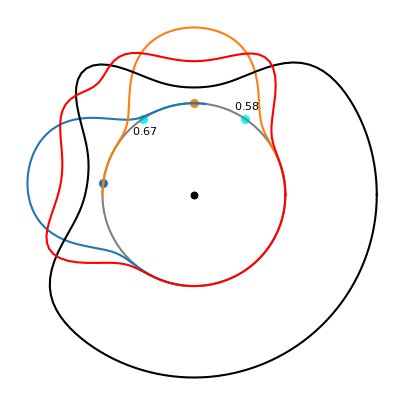

In [29]:
gallery_class_angles = [0.48, 0.25]
ident_uncertain_test_point = (
    gallery_class_angles[-1] + gallery_class_angles[-2]
) / 2 - 0.02
test_points_angles = [
    ident_uncertain_test_point,
    gallery_class_angles[-1] - (ident_uncertain_test_point - gallery_class_angles[-1]),
]

gallery_class_angles = np.array(gallery_class_angles) * 2 * np.pi
test_points_angles = np.array(test_points_angles) * 2 * np.pi
theta = np.linspace(0, 2 * np.pi, 150)
a = np.cos(theta)
b = np.sin(theta)
kappa = 15
beta = 0.5


dot_size = 30
colors = list(mcolors.TABLEAU_COLORS)[: len(gallery_class_angles)]
test_color = "cyan"
fig, ax = plt.subplots(figsize=(5, 5))
# plot circle
ax.plot(a, b, color="gray")

draw_dencity_angles = np.linspace(-np.pi / 2, np.pi / 2, 150)

mus = np.stack([np.cos(gallery_class_angles), np.sin(gallery_class_angles)], axis=0)
class_to_class_probs = []

for i, (angle, color) in enumerate(zip(gallery_class_angles, colors)):
    mu_c = mus[:, i]
    plot_angles = angle + draw_dencity_angles
    zs = get_vectors_by_angle(plot_angles)
    class_probes = compute_class_probs(i, zs, mus, kappa, beta)
    v = zs.T * (1 + class_probes[np.newaxis, :])
    ax.plot(v[0], v[1], c=color)

    ax.scatter([np.cos(angle)], [np.sin(angle)], c=color, s=dot_size)
    ax.scatter([0], [0], color="black", s=20)

    # plot decity
    # ax.scatter(points[:, 0], points[:, 1], color=color, s=3)

# plot_uniform_prob
zs = get_vectors_by_angle(theta)
class_probes = compute_class_probs(mus.shape[1], zs, mus, kappa, beta)
v = zs.T * (1 + class_probes[np.newaxis, :])
ax.plot(v[0], v[1], color="black")

# plot entropy

all_probs = []
for i in range(mus.shape[1] + 1):
    class_probes = compute_class_probs(i, zs, mus, kappa, beta)
    all_probs.append(class_probes)
all_probs = np.stack(all_probs, axis=0)
entr = -np.sum(all_probs * np.log(all_probs), axis=0)

v = zs.T * (1 + entr[np.newaxis, :])
ax.plot(v[0], v[1], color="red")

# plot test points
for test_angle in test_points_angles:
    ax.scatter([np.cos(test_angle)], [np.sin(test_angle)], c=test_color, s=dot_size)

test_point_vectors = get_vectors_by_angle(test_points_angles)
# entropy value

probs_at_test_points = []
for i in range(mus.shape[1] + 1):
    class_probes = compute_class_probs(i, test_point_vectors, mus, kappa, beta)
    probs_at_test_points.append(class_probes)
probs_at_test_points = np.stack(probs_at_test_points, axis=0)

entr_test = -np.sum(probs_at_test_points * np.log(probs_at_test_points), axis=0)
entr_test = np.round(entr_test, 2)
ax.annotate(
    f"${entr_test[0]}$",
    xy=test_point_vectors[0],
    xytext=[test_point_vectors[0][0] - 0.12, test_point_vectors[0][1] - 0.18],
    fontsize=8,
)
ax.annotate(
    f"${entr_test[1]}$",
    xy=test_point_vectors[1],
    xytext=[test_point_vectors[1][0] - 0.12, test_point_vectors[1][1] + 0.1],
    fontsize=8,
)

fig.gca().set_aspect("equal")
ax.axis("off")
fig.show()
# plt.savefig('1.png')

In [19]:
-np.sum(all_probs * np.log(all_probs), axis=0)

array([2.12407352e-05, 3.82235789e-05, 6.85690668e-05, 1.22469209e-04,
       2.17515750e-04, 3.83689165e-04, 6.71350684e-04, 1.16372849e-03,
       1.99586427e-03, 3.38238398e-03, 5.65651509e-03, 9.32201398e-03,
       1.51173058e-02, 2.40860270e-02, 3.76388530e-02, 5.75767152e-02,
       8.60255142e-02, 1.25212127e-01, 1.77005830e-01, 2.42188489e-01,
       3.19541045e-01, 4.05054769e-01, 4.91797366e-01, 5.70935653e-01,
       6.33900871e-01, 6.74859707e-01, 6.92238032e-01, 6.88575763e-01,
       6.69051054e-01, 6.39646902e-01, 6.05770738e-01, 5.71593752e-01,
       5.39965615e-01, 5.12635738e-01, 4.90566429e-01, 4.74220990e-01,
       4.63783770e-01, 4.59308300e-01, 4.60803528e-01, 4.68268811e-01,
       4.81683065e-01, 5.00946549e-01, 5.25767474e-01, 5.55483023e-01,
       5.88811117e-01, 6.23555258e-01, 6.56342095e-01, 6.82562266e-01,
       6.96773700e-01, 6.93807223e-01, 6.70541647e-01, 6.27780376e-01,
       5.71214473e-01, 5.10660005e-01, 4.57694255e-01, 4.22725911e-01,
      